In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("preparedData.xlsx")

In [3]:
ni_data = pd.read_excel("ni_smoothed.xlsx")

In [4]:
ni_data.columns

Index(['date', 'newCasesByPublishDateSmoothed'], dtype='object')

In [5]:
data = pd.merge(data, ni_data, left_on='date', right_on='date', how='left')

In [6]:
data.fillna(0, inplace=True)

In [7]:
data.columns

Index(['date', 'new_cases', 'new_cases_smoothed', 'reproduction_rate',
       'new_tests', 'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'life_expectancy', 'human_development_index', 'covid: (Ireland)',
       'COVID-19 testing: (Ireland)', 'COVID-19 rapid antigen test: (Ireland)',
       'Health Service Executive: (Ireland)', 'Vaccination: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'pharmacy near me: (Ireland)',
       'Treatment and m

In [8]:
data['new_cases_smoothed'] = data['new_cases_smoothed']+data['newCasesByPublishDateSmoothed']

In [9]:
data.head(5)

,date,new_cases,new_cases_smoothed,reproduction_rate,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,...,covid test dublin: (Ireland),covid test centre: (Ireland),hse covid vaccine: (Ireland),hse vaccine portal: (Ireland),hse portal vaccine: (Ireland),pcr test hse: (Ireland),hse covid test: (Ireland),hse vaccine registration: (Ireland),how long will it take to vaccinate ireland: (Ireland),newCasesByPublishDateSmoothed
0,2020-03-15,0,207.701934,2.51,0,0.0,0.0,0,0,0,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,191.987934
1,2020-03-16,40,206.904197,2.59,0,0.0,0.0,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,185.761197
2,2020-03-17,54,207.022704,2.70,0,0.0,0.0,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,180.022704
3,2020-03-18,69,210.077194,2.78,0,0.0,0.0,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,174.506194
4,2020-03-19,265,242.836522,2.84,946,0.0,0.0,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,169.407522


In [10]:
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', ascending=True, inplace=True)
data = data.set_index('date')

In [11]:
data.drop(columns=['tests_per_case', 'new_cases','new_tests',
            'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations','population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'life_expectancy', 'human_development_index', 
       'COVID-19 testing: (Ireland)', 'COVID-19 rapid antigen test: (Ireland)',
       'Health Service Executive: (Ireland)', 'Vaccination: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'pharmacy near me: (Ireland)',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'book covid test: (Ireland)_y', 'covid test dublin: (Ireland)',
       'covid test centre: (Ireland)', 'hse covid vaccine: (Ireland)',
       'hse vaccine portal: (Ireland)', 'hse portal vaccine: (Ireland)',
       'pcr test hse: (Ireland)', 'hse covid test: (Ireland)',
       'hse vaccine registration: (Ireland)',
       'how long will it take to vaccinate ireland: (Ireland)','newCasesByPublishDateSmoothed'],inplace=True)

In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed,702.0,2.098751e+03,3.493779e+03,11.571,448.479583,854.09339,1.997520e+03,2.375200e+04
reproduction_rate,702.0,1.076068e+00,3.489241e-01,0.000,0.880000,1.02000,1.250000e+00,2.840000e+00
positive_rate,702.0,7.688519e-02,9.587108e-02,0.000,0.022800,0.04015,8.922500e-02,5.523000e-01
total_vaccinations,702.0,2.886069e+06,3.631357e+06,0.000,0.000000,447297.00000,6.680368e+06,1.050748e+07
stringency_index,702.0,6.209577e+01,1.978799e+01,0.000,44.440000,55.56000,8.148000e+01,9.074000e+01
covid: (Ireland),702.0,2.967664e+01,1.365269e+01,0.000,20.250000,26.00000,3.400000e+01,1.000000e+02


In [13]:
df = data.copy(deep=True)

In [14]:
df.loc[:,'ncs'] = df.loc[:,'new_cases_smoothed'].shift()
df.loc[:,'ncs_diff'] = df.loc[:,'ncs'].diff()
df.loc[:,'ncs2'] = df.loc[:,'ncs'].shift()
df.loc[:,'ncs_diff2'] = df.loc[:,'ncs2'].diff()
df.loc[:,'ncs3'] = df.loc[:,'ncs2'].shift()
df.loc[:,'ncs_diff3'] = df.loc[:,'ncs3'].diff()
df.loc[:,'ncs4'] = df.loc[:,'ncs3'].shift()
df.loc[:,'ncs_diff4'] = df.loc[:,'ncs4'].diff()
df.loc[:,'ncs5'] = df.loc[:,'ncs4'].shift()
df.loc[:,'ncs_diff5'] = df.loc[:,'ncs5'].diff()
df.loc[:,'ncs6'] = df.loc[:,'ncs5'].shift()
df.loc[:,'ncs_diff6'] = df.loc[:,'ncs6'].diff()
df.loc[:,'ncs7'] = df.loc[:,'ncs6'].shift()
df.loc[:,'ncs_diff7'] = df.loc[:,'ncs7'].diff()

In [15]:
# USE THIS

df.loc[:,'google'] = df.loc[:,'covid: (Ireland)'].shift()
df.loc[:,'google_diff'] = df.loc[:,'google'].diff()
df.loc[:,'google2'] = df.loc[:,'google'].shift()
df.loc[:,'google_diff2'] = df.loc[:,'google2'].diff()
df.loc[:,'google3'] = df.loc[:,'google2'].shift()
df.loc[:,'google_diff3'] = df.loc[:,'google3'].diff()
df.loc[:,'google4'] = df.loc[:,'google3'].shift()
df.loc[:,'google_diff4'] = df.loc[:,'google4'].diff()
df.loc[:,'google5'] = df.loc[:,'google4'].shift()
df.loc[:,'google_diff5'] = df.loc[:,'google5'].diff()
df.loc[:,'google6'] = df.loc[:,'google5'].shift()
df.loc[:,'google_diff6'] = df.loc[:,'google6'].diff()
df.loc[:,'google7'] = df.loc[:,'google6'].shift()
df.loc[:,'google_diff7'] = df.loc[:,'google7'].diff()

In [16]:
df = df.fillna(0)

In [17]:
df.tail(5)

,new_cases_smoothed,reproduction_rate,positive_rate,total_vaccinations,stringency_index,covid: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2022-02-10,5281.571000,0.91,0.3047,10475477,23.15,16.0,5340.42900,-37.57100,5378.000,-61.143,...,16.0,-1.0,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0
2022-02-11,5270.286000,0.89,0.3088,10485170,23.15,16.0,5281.57100,-58.85800,5340.429,-37.571,...,16.0,0.0,16.0,-1.0,17.0,0.0,17.0,0.0,17.0,0.0
2022-02-12,5270.286000,0.87,0.0000,10497384,0.00,16.0,5270.28600,-11.28500,5281.571,-58.858,...,16.0,0.0,16.0,0.0,16.0,-1.0,17.0,0.0,17.0,0.0
2022-02-13,6315.613280,0.00,0.0000,10507477,0.00,16.0,5270.28600,0.00000,5270.286,-11.285,...,16.0,0.0,16.0,0.0,16.0,0.0,16.0,-1.0,17.0,0.0
2022-02-14,5976.855719,0.00,0.0000,0,0.00,0.0,6315.61328,1045.32728,5270.286,0.000,...,16.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0,16.0,-1.0


In [18]:
df.shape

(702, 34)

In [19]:
n = len(df)

In [20]:
df.columns

Index(['new_cases_smoothed', 'reproduction_rate', 'positive_rate',
       'total_vaccinations', 'stringency_index', 'covid: (Ireland)', 'ncs',
       'ncs_diff', 'ncs2', 'ncs_diff2', 'ncs3', 'ncs_diff3', 'ncs4',
       'ncs_diff4', 'ncs5', 'ncs_diff5', 'ncs6', 'ncs_diff6', 'ncs7',
       'ncs_diff7', 'google', 'google_diff', 'google2', 'google_diff2',
       'google3', 'google_diff3', 'google4', 'google_diff4', 'google5',
       'google_diff5', 'google6', 'google_diff6', 'google7', 'google_diff7'],
      dtype='object')

In [21]:
variables = df.columns.drop(['new_cases_smoothed'])

In [22]:
X_train = df.iloc[0:int(n*0.7)].drop('new_cases_smoothed', axis=1)
y_train = df.iloc[0:int(n*0.7)].drop(columns=variables, axis=1)

In [23]:
X_test = df.iloc[int(n*0.7):int(n*0.9)].drop('new_cases_smoothed',axis=1)
y_test = df.iloc[int(n*0.7):int(n*0.9)].drop(columns=variables, axis=1)

In [24]:
X_val = df.iloc[int(n*0.9):].drop('new_cases_smoothed', axis=1)
y_val = df.iloc[int(n*0.9):].drop(columns=variables, axis=1)

In [25]:
model = MLPRegressor()

In [26]:
param_search = {
    "hidden_layer_sizes": [(1,),(50,),(100,),(150,),(200,)],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.00005,0.0005, 0.005],
    "learning_rate": ['constant', 'invscaling', 'adaptive']
}

In [27]:
tsvc = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tsvc, param_grid=param_search, scoring='r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [28]:
print(best_model)

MLPRegressor(activation='identity', alpha=0.005, learning_rate='adaptive')


In [29]:
print(best_score)

0.6243367148544514


In [30]:
from sklearn.metrics import r2_score

y_pred = best_model.predict(X_test)

print(r2_score(y_test, y_pred))

0.9878522399414508


In [31]:
y_val_pred = best_model.predict(X_val)

In [32]:
print(r2_score(y_val, y_val_pred))

0.9522867003828527


In [33]:
y_test['predictions'] = y_pred.tolist()


<AxesSubplot:xlabel='date'>

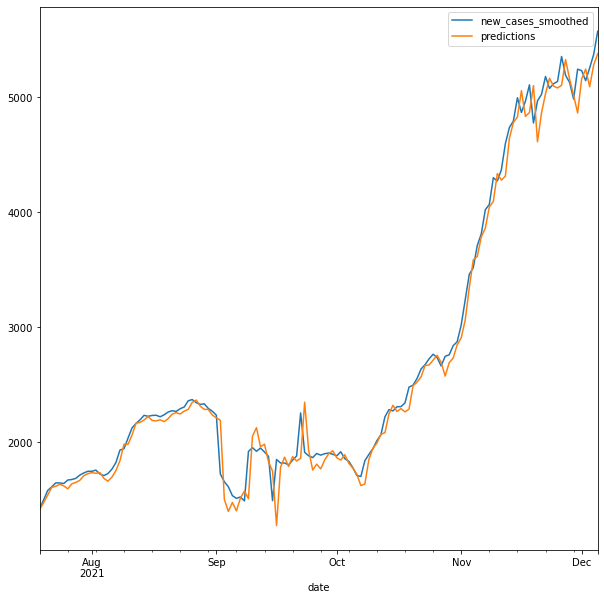

In [34]:
y_test.reset_index(inplace=True)
y_test.plot(x='date', y=['new_cases_smoothed', 'predictions'], kind="line", figsize=(10,10))

In [35]:
y_val['predictions'] = y_val_pred.tolist()

In [36]:
y_val.reset_index(inplace=True)

<AxesSubplot:xlabel='date'>

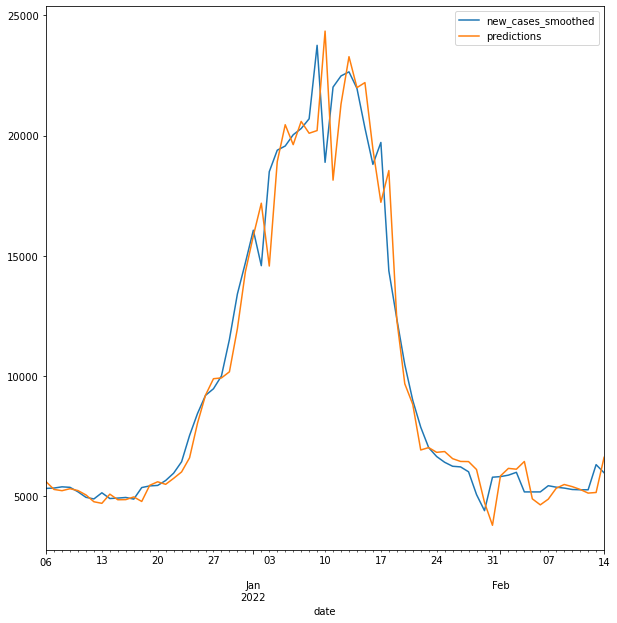

In [197]:
y_val.plot(x='date', y=['new_cases_smoothed', 'predictions'], kind="line", figsize=(10,10))

In [198]:
new = pd.read_csv("NEW COVID DATA2.csv")

In [199]:
new['date'] = pd.to_datetime(new['date'])
new.sort_values(by='date', ascending=True, inplace=True)
new = new.set_index('date')

In [200]:
new.head()

,new_cases_smoothed,reproduction_rate,positive_rate,total_vaccinations,stringency_index,covid: (Ireland)
date,,,,,,
2022-01-03,3380.286,0.93,0.2773,10616831,23.15,75
2022-02-03,3269.000,0.94,0.2740,10621177,23.15,84
2022-02-22,4288.429,0.96,0.2770,10583588,23.15,92
2022-02-23,4125.143,0.95,0.2769,10588597,23.15,82
2022-02-24,3939.857,0.92,0.2741,10593703,23.15,71


In [201]:
new.loc[:,'ncs'] = new.loc[:,'new_cases_smoothed'].shift()
new.loc[:,'ncs_diff'] = new.loc[:,'ncs'].diff()
new.loc[:,'ncs2'] = new.loc[:,'ncs'].shift()
new.loc[:,'ncs_diff2'] = new.loc[:,'ncs2'].diff()
new.loc[:,'ncs3'] = new.loc[:,'ncs2'].shift()
new.loc[:,'ncs_diff3'] = new.loc[:,'ncs3'].diff()
new.loc[:,'ncs4'] = new.loc[:,'ncs3'].shift()
new.loc[:,'ncs_diff4'] = new.loc[:,'ncs4'].diff()
new.loc[:,'ncs5'] = new.loc[:,'ncs4'].shift()
new.loc[:,'ncs_diff5'] = new.loc[:,'ncs5'].diff()
new.loc[:,'ncs6'] = new.loc[:,'ncs5'].shift()
new.loc[:,'ncs_diff6'] = new.loc[:,'ncs6'].diff()
new.loc[:,'ncs7'] = new.loc[:,'ncs6'].shift()
new.loc[:,'ncs_diff7'] = new.loc[:,'ncs7'].diff()

In [202]:
new.loc[:,'google'] = new.loc[:,'covid: (Ireland)'].shift()
new.loc[:,'google_diff'] = new.loc[:,'google'].diff()
new.loc[:,'google2'] = new.loc[:,'google'].shift()
new.loc[:,'google_diff2'] = new.loc[:,'google2'].diff()
new.loc[:,'google3'] = new.loc[:,'google2'].shift()
new.loc[:,'google_diff3'] = new.loc[:,'google3'].diff()
new.loc[:,'google4'] = new.loc[:,'google3'].shift()
new.loc[:,'google_diff4'] = new.loc[:,'google4'].diff()
new.loc[:,'google5'] = new.loc[:,'google4'].shift()
new.loc[:,'google_diff5'] = new.loc[:,'google5'].diff()
new.loc[:,'google6'] = new.loc[:,'google5'].shift()
new.loc[:,'google_diff6'] = new.loc[:,'google6'].diff()
new.loc[:,'google7'] = new.loc[:,'google6'].shift()
new.loc[:,'google_diff7'] = new.loc[:,'google7'].diff()

In [203]:
new.shape

(17, 34)

In [204]:
new.fillna(0, inplace=True)

In [205]:
new_var = new.drop(columns=['new_cases_smoothed'])

In [206]:
new_var = new_var.iloc[2:]

In [207]:
new_var.shape

(15, 33)

In [208]:
new_pred = best_model.predict(new_var)

In [209]:
new = new.iloc[2:]

In [210]:
new_y = new['new_cases_smoothed']

In [211]:
new_y = new_y.to_frame()

In [212]:
new_y

,new_cases_smoothed
date,
2022-02-22,4288.429
2022-02-23,4125.143
2022-02-24,3939.857
2022-02-25,3869.714
2022-02-26,3869.714
2022-02-27,3869.714
2022-02-28,3377.714
2022-03-03,3313.857
2022-04-03,3269.714


In [213]:
print(r2_score(new_y, new_pred))

-9.064811605149202


In [214]:
new_pred

array([ 726.45880117, 1791.67209312, 2696.24369242, 2670.0151208 ,
       2612.50990413, 3639.33211009, 3667.4751179 , 3112.73485147,
       3096.87069381, 3136.07360129, 3147.16028609, 3288.63970171,
       3181.02916725, 3333.81860989, 3016.83445931])

In [215]:
new_y['predictions'] = new_pred.tolist()

In [216]:
new_y_new = new_y.iloc[5:]

In [217]:
new_y_new.reset_index(inplace=True)

In [218]:
new_y_new

,date,new_cases_smoothed,predictions
0,2022-02-27,3869.714,3639.332110
1,2022-02-28,3377.714,3667.475118
2,2022-03-03,3313.857,3112.734851
3,2022-04-03,3269.714,3096.870694
4,2022-05-03,3269.714,3136.073601
5,2022-06-03,3269.714,3147.160286
6,2022-07-03,3167.000,3288.639702
7,2022-08-03,3318.000,3181.029167
8,2022-09-03,3083.143,3333.818610
9,2022-10-03,3085.143,3016.834459


<AxesSubplot:xlabel='date'>

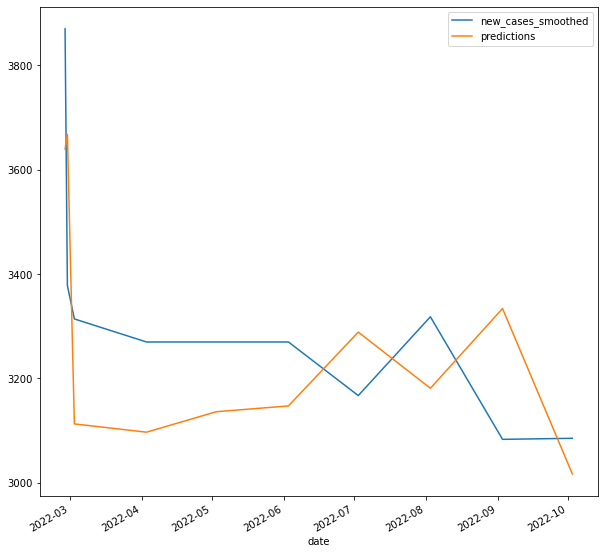

In [219]:
new_y_new.plot(x='date', y=['new_cases_smoothed', 'predictions'], kind="line", figsize=(10,10))

In [220]:
new_y_new['date'] = pd.to_datetime(new_y_new['date'])

x = new_y_new['date']
y = new_y_new[['new_cases_smoothed', 'predictions']]


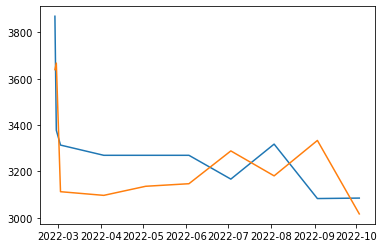

In [223]:
plt.rcParams["date.autoformatter.day"] = "%Y-%d-%m"
plt.plot(x,y)
